<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/master/notebooks/fpn_builder_random_rectangles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization==0.3.0.dev6
! pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git

  Cloning https://github.com/kmkolasinski/keras_detection.git to /tmp/pip-req-build-_9w98uf3
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-_9w98uf3
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=74426 sha256=3e1b5e71c721ab7eb9720a7f75150997383ce2519fb3f3df32ee9bd131d0a182
  Stored in directory: /tmp/pip-ephem-wheel-cache-wd35awuu/wheels/9c/23/23/2d3299a84b3beda7addbe5f17af1aa74b0e15fd87214803132
Successfully built keras-detection
  Found existing installation: keras-detection 0.1
    Uninstalling keras-detection-0.1:
      Successfully uninstalled keras-detection-0.1


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import keras_detection.datasets.datasets_ops as datasets_ops
import keras_detection.datasets.random_rectangles as random_rects
from keras_detection import ImageData

In [0]:
keras = tf.keras

In [0]:
# Run this if you see tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
_logger.propagate = False
if len(_logger.handlers) > 1:
  _logger.handlers.pop(0)

Random rectangles detection dataset

In [4]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(min_max_num_boxes=(5, 20))
)
dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [0]:
# Benchmark dataset sampling
# %timeit next(iter(dataset))

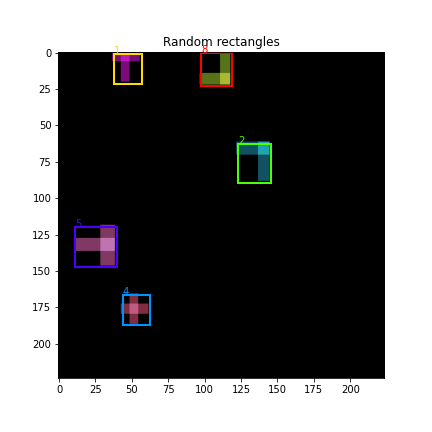

In [6]:
image_data = ImageData.from_dict(next(iter(dataset)))
image_data.draw_boxes(title="Random rectangles")

# Build dataset (batched) and FPN detection model 

In [0]:
import keras_detection.datasets.datasets_ops as datasets_ops

def aug_fn(image_data: ImageData) -> ImageData:
    image = tf.cast(image_data.features.image, tf.float32)
    # example augmentation 
    image = tf.image.random_brightness(image, max_delta=1.2)
    return image_data.replace_image(image)


image_dim = 224
batch_size = 32
shuffle_buffer_size = 1 # we don't have to shuffle random rectangles dataset
num_classes = 9 # random rectangles have 9 classes
num_parallel_calls = tf.data.experimental.AUTOTUNE

In [0]:
dataset = datasets_ops.from_numpy_generator(
    random_rects.create_random_rectangles_dataset_generator(image_size=(image_dim, image_dim), min_max_num_boxes=(5, 20))
)

train_dataset = datasets_ops.prepare_dataset(
    dataset,
    model_image_size=(image_dim, image_dim),
    augmentation_fn=aug_fn,
    num_epochs=-1,
    batch_size=batch_size ,
    shuffle_buffer_size=shuffle_buffer_size,
    prefetch_buffer_size=4,
    num_parallel_calls=num_parallel_calls
)

In [0]:
# %timeit next(iter(train_dataset))

# Build model builder 

In [0]:
from keras_detection import FPNBuilder
from keras_detection.tasks import standard_tasks
from keras_detection.backbones import resnet
from keras_detection.utils import plotting


backbone = resnet.ResNetBackbone(
    input_shape=(image_dim, image_dim, 3),
    units_per_block=(1, 1),
    num_last_blocks=1, # number of feature pyramids, setting single feature map
)

# Setting task quantizable to False will make that only the resnet backbone will be quantized
# other layers (tasks (heads) layers) will be trained in full precision.  

tasks = [
    # predicts objectnes score for each anchor
    standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin", quantizable=False),
    # predicts [height, with, y_center, x_center] location of the box
    standard_tasks.get_box_shape_task("box_shape", quantizable=False),
    # predicts [num_classes] for each anchor (focal loss is not supported yet)
    standard_tasks.get_multiclass_task(num_classes, fl_gamma=0.0, label_smoothing=0, activation='softmax', quantizable=False),
]

builder = FPNBuilder(backbone=backbone, tasks=tasks)

In [10]:
model = builder.build()

INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f8ca01a9ac8>
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)


In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model (Model)                   [(None, 56, 56, 64), 317650      tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model[1][1]                      
____________________________________________________________________________________________

In [0]:
# check resnet backbone
# model.layers[2].summary()

## Prepare labels (targets) for objectness, box shape regression and classes

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [11]:
prepared_train_dataset

<MapDataset shapes: ({image: (32, 224, 224, 3)}, {fm28x28/objectness: (32, 28, 28, 2), fm28x28/box_shape: (32, 28, 28, 5), fm28x28/classes: (32, 28, 28, 11)}), types: ({image: tf.float32}, {fm28x28/objectness: tf.float32, fm28x28/box_shape: tf.float32, fm28x28/classes: tf.float32})>

In [0]:
features, labels = next(iter(prepared_train_dataset))

Validating targets: objectness, box prediction and class predictions heads

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


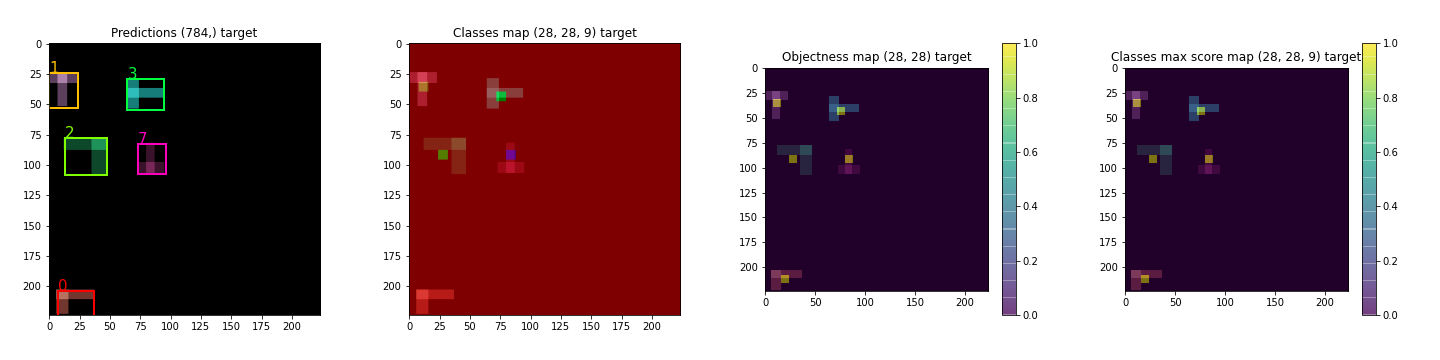

In [13]:
fm = "fm28x28"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 0
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

# Train standard Keras model and export to TFLite 

In [0]:
import keras_detection.models.utils as kd_utils

l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 50s 99ms/step - loss: 0.3900 - fm28x28/objectness_loss: 0.0640 - fm28x28/box_shape_loss: 0.0121 - fm28x28/classes_loss: 0.1844 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.1568 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9647 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.8923 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0858 - fm28x28/classes_MulticlassAccuracyMetric: 0.7115
Epoch 2/5
500/500 [==============================] - 50s 100ms/step - loss: 0.1297 - fm28x28/objectness_loss: 0.0204 - fm28x28/box_shape_loss: 0.0069 - fm28x28/classes_loss: 0.0204 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2003 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9695 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9327 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0485 - fm28x28/classes_MulticlassAccuracyMetric: 0.9161
Epoch 3/5
500/500 [==============================] - 50s 100ms/step - loss: 0.1073 - fm28x2

In [19]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=2, steps_per_epoch=500)

Epoch 1/2
500/500 [==============================] - 50s 100ms/step - loss: 0.0869 - fm28x28/objectness_loss: 0.0169 - fm28x28/box_shape_loss: 0.0043 - fm28x28/classes_loss: 0.0113 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2323 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9727 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9419 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0408 - fm28x28/classes_MulticlassAccuracyMetric: 0.9482
Epoch 2/2
500/500 [==============================] - 50s 100ms/step - loss: 0.0832 - fm28x28/objectness_loss: 0.0167 - fm28x28/box_shape_loss: 0.0041 - fm28x28/classes_loss: 0.0109 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2333 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9733 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9418 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0403 - fm28x28/classes_MulticlassAccuracyMetric: 0.9494


In [0]:
!mkdir --parents models
model.save_weights("models/non-quantized-model.h5")

In [0]:
model.load_weights("models/non-quantized-model.h5")

## Test trained model

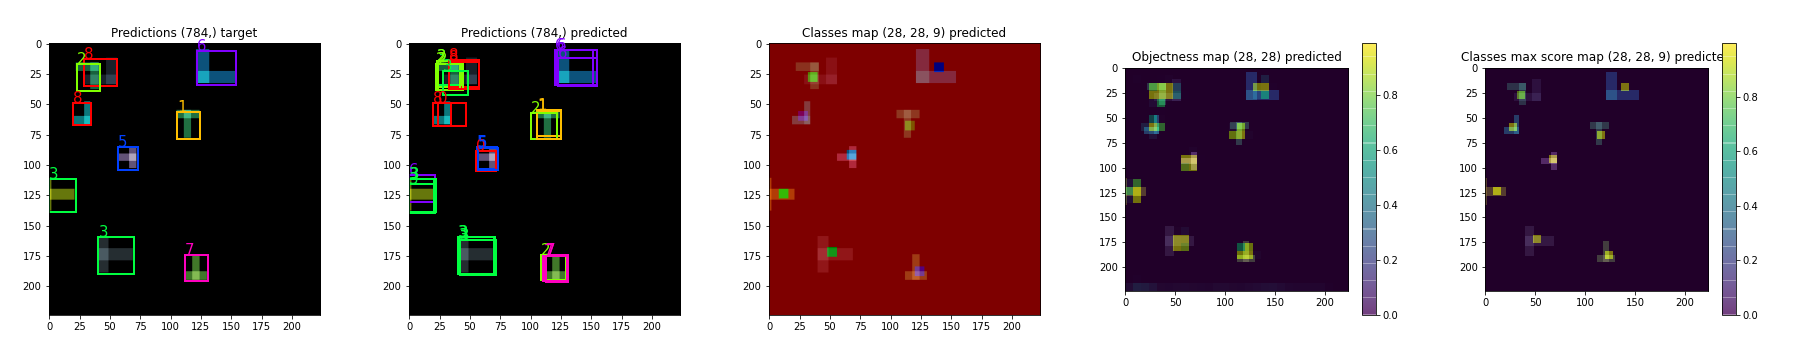

In [21]:
def draw_predictions(model, features, labels, idx = 0, fm = "fm28x28", score_threshold = 0.5):
  
  predictions = model.predict(features)
  predictions = builder.predictions_to_dict(predictions, postprocess=True)

  
  targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
  targets = builder.predictions_to_dict(targets, postprocess=True)

  target=dict(
      objectness=targets[f'{fm}/objectness'][idx],
      boxes_shape_map=targets[f'{fm}/box_shape'][idx],
      classes_map=targets[f'{fm}/classes'][idx],
  )

  predicted=dict(
      objectness=predictions[f'{fm}/objectness'][idx],
      boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
      classes_map=predictions[f'{fm}/classes'][idx],
  )

  render = plotting.draw_compares(    
      target=target,
      predicted=predicted,
      draw_fns=[
          plotting.draw_boxes, 
          plotting.draw_classes_map,
          plotting.draw_objectness_map,
          plotting.draw_classes_max_score_map,
      ],
      image=features['image'][idx] / 255,
      score_threshold=score_threshold,
  )
  return render

features, labels = next(iter(prepared_train_dataset))
draw_predictions(model, features, labels, fm = "fm28x28")

## Export model to tflite

In [25]:
# creates two versions of the model:  
#  - models/non-quantized-model.tflite
#  - models/non-quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(    
    model, 
    save_path="models/non-quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between (per image data)
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=True # Use represenetative dataset to create integer quantized model
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity:0", shape=(1, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity:0", shape=(1, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes/Identity:0", shape=(1, 784, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Testing tflite model for N=1 iterations ..


INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 59,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 784,   4], dtype=int32),
  'shape_signature': array([  1, 784,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 64,
  'name': 'export/classes/output',


INFO:tensorflow:Test finished in 0.066985 seconds


INFO:tensorflow:Model saved to models/non-quantized-model.tflite


INFO:tensorflow:Model saved to models/non-quantized-model.tflite


INFO:tensorflow:Converting quantized model


INFO:tensorflow:Converting quantized model


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Model converted successfully 


INFO:tensorflow:Testing tflite model for N=1 iterations ..


INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 70,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 71,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 784,   4], dtype=int32),
  'shape_signature': array([  1, 784,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 72,
  'name': 'export/classes/output',

INFO:tensorflow:Test finished in 1.871869 seconds


INFO:tensorflow:Quantized model saved to models/non-quantized-model.quantized.tflite


INFO:tensorflow:Quantized model saved to models/non-quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.tflite
100%|██████████| 16/16 [00:01<00:00, 10.50it/s]

INFO:tensorflow:Measured deviation between keras and tflite model:



INFO:tensorflow:Measured deviation between keras and tflite model:


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001115 
	RMSE    =  0.005667 
	Keras   = N(μ=  0.054421, σ=  0.197299)
	tflite  = N(μ=  0.054398, σ=  0.197127)
 - export/box_shape/output   
	MAE     =  0.001186 
	RMSE    =  0.001677 
	Keras   = N(μ=  0.275871, σ=  0.304433)
	tflite  = N(μ=  0.276498, σ=  0.303995)
 - export/classes/output     
	MAE     =  0.000033 
	RMSE    =  0.000762 
	Keras   = N(μ=  0.001661, σ=  0.035921)
	tflite  = N(μ=  0.001654, σ=  0.035881)


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001115 
	RMSE    =  0.005667 
	Keras   = N(μ=  0.054421, σ=  0.197299)
	tflite  = N(μ=  0.054398, σ=  0.197127)
 - export/box_shape/output   
	MAE     =  0.001186 
	RMSE    =  0.001677 
	Keras   = N(μ=  0.275871, σ=  0.304433)
	tflite  = N(μ=  0.276498, σ=  0.303995)
 - export/classes/output     
	MAE     =  0.000033 
	RMSE    =  0.000762 
	Keras   = N(μ=  0.001661, σ=  0.035921)
	tflite  = N(μ=  0.001654, σ=  0.035881)


INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite


INFO:tensorflow:Testing converted model: non-quantized-model.quantized.tflite
100%|██████████| 16/16 [00:30<00:00,  1.91s/it]

INFO:tensorflow:Measured deviation between keras and tflite model:



INFO:tensorflow:Measured deviation between keras and tflite model:


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001633 
	RMSE    =  0.007339 
	Keras   = N(μ=  0.065923, σ=  0.221597)
	tflite  = N(μ=  0.065700, σ=  0.221018)
 - export/box_shape/output   
	MAE     =  0.002269 
	RMSE    =  0.002746 
	Keras   = N(μ=  0.279193, σ=  0.301771)
	tflite  = N(μ=  0.278788, σ=  0.302269)
 - export/classes/output     
	MAE     =  0.000087 
	RMSE    =  0.000970 
	Keras   = N(μ=  0.002029, σ=  0.040027)
	tflite  = N(μ=  0.002004, σ=  0.039895)


INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001633 
	RMSE    =  0.007339 
	Keras   = N(μ=  0.065923, σ=  0.221597)
	tflite  = N(μ=  0.065700, σ=  0.221018)
 - export/box_shape/output   
	MAE     =  0.002269 
	RMSE    =  0.002746 
	Keras   = N(μ=  0.279193, σ=  0.301771)
	tflite  = N(μ=  0.278788, σ=  0.302269)
 - export/classes/output     
	MAE     =  0.000087 
	RMSE    =  0.000970 
	Keras   = N(μ=  0.002029, σ=  0.040027)
	tflite  = N(μ=  0.002004, σ=  0.039895)


In [26]:
tflite_models_paths

[PosixPath('models/non-quantized-model.tflite'),
 PosixPath('models/non-quantized-model.quantized.tflite')]

# Train Quantized model and export to TFLite

In [27]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5"
)

INFO:tensorflow:Building quantized model with batch_size = None


INFO:tensorflow:Building quantized model with batch_size = None


INFO:tensorflow:Input image: (None, 224, 224, 3)


INFO:tensorflow:Input image: (None, 224, 224, 3)


INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fa107f22cf8>


INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fa107f22cf8>


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow: Processing feature map (fm28x28)


INFO:tensorflow: Processing feature map (fm28x28)


INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5


INFO:tensorflow:Loading weights of base model: models/non-quantized-model.h5


INFO:tensorflow:Building graph with quantization enabled


INFO:tensorflow:Building graph with quantization enabled


INFO:tensorflow:Input image: (None, 224, 224, 3)


INFO:tensorflow:Input image: (None, 224, 224, 3)


INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fa107f22cf8>


INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7fa107f22cf8>


INFO:tensorflow:Running quantization for model backbone: model


INFO:tensorflow:Running quantization for model backbone: model


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']


INFO:tensorflow: Processing feature map (fm28x28)


INFO:tensorflow: Processing feature map (fm28x28)


In [0]:
# Run this if you see tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
if len(_logger.handlers) > 1:
  _logger.handlers.pop(0)

In [29]:
# heads are not quantized (they have quantizable = Fales)
quantized_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_3 (TensorFl [(None, 224, 224, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
model (Model)                   [(None, 56, 56, 64), 318989      tf_op_layer_RealDiv_3[0][0]      
__________________________________________________________________________________________________
head/fm28x28/fm28x28/objectness (None, 28, 28, 1)    74113       model[1][1]                      
____________________________________________________________________________________________

In [30]:
# check if resnet is quantized
quantized_model.layers[2].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
quantize_layer (QuantizeLayer)  (None, 224, 224, 3)  3           image[0][0]                      
__________________________________________________________________________________________________
quant_conv0-pre (QuantizeWrappe (None, 224, 224, 3)  16          quantize_layer[1][0]             
__________________________________________________________________________________________________
quant_bn_data (QuantizeWrapper) (None, 224, 224, 3)  12          quant_conv0-pre[0][0]            
______________________________________________________________________________________________

In [31]:
# check first head
quantized_model.layers[3].summary()

Model: "head/fm28x28/fm28x28/objectness"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 128)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         65        
Total params: 74,113
Trainable params: 73,985
Non-trainable params: 128
_________________________________________________________________


In [32]:
# test metrics after quantization, they should be worse
# we can evaluate on train dataset since every batch is different
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 10s 96ms/step - loss: 0.2518 - fm28x28/objectness_loss: 0.0208 - fm28x28/box_shape_loss: 0.0214 - fm28x28/classes_loss: 0.0168 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2155 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9696 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.8919 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0423 - fm28x28/classes_MulticlassAccuracyMetric: 0.9214


[0.2518233060836792,
 0.020775852724909782,
 0.021421391516923904,
 0.016833465546369553,
 0.21548640727996826,
 0.9695624709129333,
 0.8918609619140625,
 0.042339082807302475,
 0.9214407205581665]

In [0]:
# quantized_model.metrics_names

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [35]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/3
500/500 [==============================] - 56s 112ms/step - loss: 0.1006 - fm28x28/objectness_loss: 0.0169 - fm28x28/box_shape_loss: 0.0058 - fm28x28/classes_loss: 0.0114 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2350 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9735 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9417 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0401 - fm28x28/classes_MulticlassAccuracyMetric: 0.9489
Epoch 2/3
500/500 [==============================] - 56s 112ms/step - loss: 0.0968 - fm28x28/objectness_loss: 0.0171 - fm28x28/box_shape_loss: 0.0054 - fm28x28/classes_loss: 0.0112 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2366 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9729 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9410 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0395 - fm28x28/classes_MulticlassAccuracyMetric: 0.9488
Epoch 3/3
500/500 [==============================] - 56s 112ms/step - loss: 0.0946 - fm28x

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

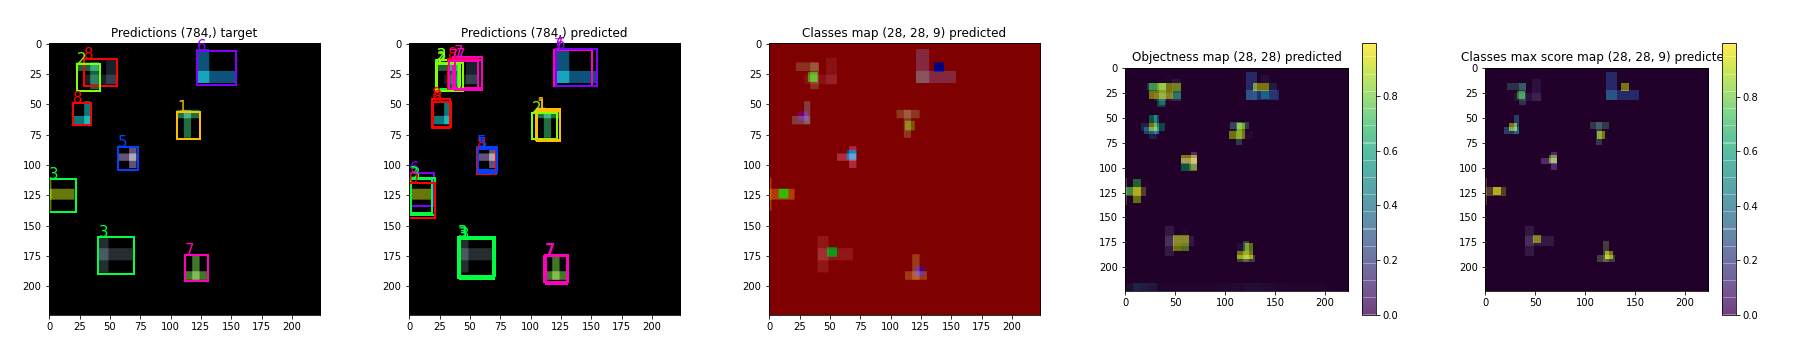

In [36]:
# features, labels = next(iter(prepared_train_dataset))
draw_predictions(quantized_model, features, labels, fm = "fm28x28")

In [37]:
builder.evaluate_model(quantized_model, train_dataset, 100)

100/100 [==============================] - 10s 101ms/step - loss: 0.1214 - fm28x28/objectness_loss: 0.0181 - fm28x28/box_shape_loss: 0.0076 - fm28x28/classes_loss: 0.0130 - fm28x28/objectness_ObjectnessPrecisionAT20pc: 0.2115 - fm28x28/objectness_ObjectnessRecallAT20pc: 0.9788 - fm28x28/objectness_ObjectnessPositivesMeanScore: 0.9588 - fm28x28/objectness_ObjectnessNegativesMeanScore: 0.0462 - fm28x28/classes_MulticlassAccuracyMetric: 0.9465


[0.12138097733259201,
 0.018140725791454315,
 0.0075699277222156525,
 0.012965776957571507,
 0.21153967082500458,
 0.9788275957107544,
 0.9587920904159546,
 0.046221569180488586,
 0.9464772939682007]

In [42]:
# creates two versions of the model:  
#  - models/quantized-model.tflite

exported_model, quantized_tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = dataset,  # dataset to the test the stats between 
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False # full integer quantization  does not work with QAT models
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_3/Identity:0", shape=(1, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_3/Identity:0", shape=(1, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_3/Identity:0", shape=(1, 784, 9), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..
Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                

100%|██████████| 16/16 [00:01<00:00,  8.72it/s]

INFO:tensorflow:Measured deviation between keras and tflite model:
INFO:tensorflow:
 - export/objectness/output  
	MAE     =  0.001198 
	RMSE    =  0.005807 
	Keras   = N(μ=  0.068794, σ=  0.225295)
	tflite  = N(μ=  0.069031, σ=  0.225529)
 - export/box_shape/output   
	MAE     =  0.000708 
	RMSE    =  0.000969 
	Keras   = N(μ=  0.289126, σ=  0.294180)
	tflite  = N(μ=  0.289334, σ=  0.294117)
 - export/classes/output     
	MAE     =  0.000044 
	RMSE    =  0.000874 
	Keras   = N(μ=  0.001729, σ=  0.037579)
	tflite  = N(μ=  0.001753, σ=  0.037619)


# Benchmark models

In [0]:
import keras_detection.evaluation.detection_metrics as det_metrics
from keras_detection.ops.python_ops import map_nested_dict
from pathlib import Path

In [0]:
all_tflite_paths = [
  Path('models/non-quantized-model.tflite'), # from Keras model
  Path('models/non-quantized-model.quantized.tflite'), # full post train quantization from Keras model
  Path('models/quantized-model.tflite'), # from QAT model
  Path('models/quantized-model.h5') # a keras model 
]

In [22]:
path = all_tflite_paths[-1]
box_detector = builder.as_box_detector(path, is_quantized=True)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f8ca01a9ac8>
INFO:tensorflow:Running quantization for model backbone: model
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity:0", shape=(None, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity:0", shape=(None, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes/Identity:0", shape=(None, 784, 9), dtype=float32)


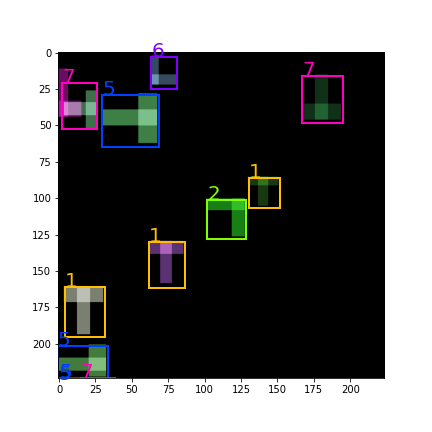

In [23]:
# Test on single prediction
train_dataset_iterator = iter(train_dataset)
batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
idx = 0
image_data = ImageData.from_dict(batch_data)
predictions = box_detector.predict(image_data.features.image)
predictions[idx].draw(image=image_data.features.image[idx], fontsize=20)

## Collecting metrics for few batches

In [27]:
from collections import defaultdict

num_batches_to_test = 5
iou_threshold = 0.5
test_models = {str(path): builder.as_box_detector(path, is_quantized=True) for path in all_tflite_paths}
test_models_metrics = defaultdict(list)

print(f"Test models: {test_models.keys()}")

for i in range(num_batches_to_test):
  print("Testing batch: ", i)
  batch_data = map_nested_dict(next(train_dataset_iterator), lambda x: x.numpy())
  image_data = ImageData.from_dict(batch_data)

  for k, predictor in test_models.items():
    print(f" => Predicting: {k}")
    predictions_per_image = predictor.predict(image_data.features.image)
    targets_per_image = image_data.labels.unbatch()
    
    metrics = []
    for target, predicted in zip(targets_per_image, predictions_per_image):
      metrics += det_metrics.image_localization_metrics(
          target=target, predicted=predicted.to_labels_frame(), 
          iou_threshold=iou_threshold
      )
    test_models_metrics[k] += metrics

INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building box predictor for TFLite model
INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 224, 224, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.resnet.ResNetBackbone object at 0x7f8ca01a9ac8>
INFO:tensorflow:Running quantization for model backbone: model
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm28x28)
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness_2/Identity:0", shape=(None, 784), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape_2/Identity:0", shape=(None, 784, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes_2/

In [29]:
import pandas as pd

data = defaultdict(list)
for model_name, metrics in test_models_metrics.items():
  for m in det_metrics.aggregate_metrics(metrics):
    data[m.name].append(m.value)
  data["model"].append(model_name)
pd.DataFrame(data).set_index("model")

,localization@0.5/precision,localization@0.5/recall,localization@0.5/f1_score
model,,,
models/non-quantized-model.tflite,0.867815,0.941396,0.898998
models/non-quantized-model.quantized.tflite,0.853812,0.935535,0.888767
models/quantized-model.tflite,0.812741,0.937666,0.865307
models/quantized-model.h5,0.817115,0.939265,0.868612
